In [9]:
options(repr.plot.width=6, repr.plot.height=4)
options(warn=-1)
packages = c("tidyverse", "survival", "ggfortify", "survminer")

## Check to see if package is available and load else install the package and its dependencies
package.check <- lapply(packages, FUN = function(x) {
  if (!require(x, character.only = TRUE)) {
    install.packages(x, dependencies = TRUE)
    library(x, character.only = TRUE)
  }
})

Loading required package: survminer
Loading required package: ggpubr
Loading required package: magrittr

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract



In [10]:
thoracic <- read.csv('data/Thoracic.txt', sep = ' ', header = F)
col_names = c("DGN", "PRE4", "PRE5", "PRE6","PRE7","PRE8","PRE9","PRE10",
              "PRE11","PRE14","PRE17","PRE19","PRE25","PRE30","PRE32","AGE","Risk1Y")

names(thoracic) <- col_names
data_set <- thoracic %>% select(PRE30, AGE, Risk1Y)
data_set$PRE30 <- as.integer(as.logical(data_set$PRE30))
data_set$Risk1Y <- as.integer(as.logical(data_set$Risk1Y ))

time <- data_set$AGE #define time
event <- data_set$Risk1Y #define event
group <- data_set$PRE30  #define groups to compare multiple survival curves

In [25]:
#Computing nonparametric estimators of the survivor function: Kaplan-Meier
kaplan_meier <- survfit(Surv(time, event) ~ 1, data = thoracic, type = "kaplan-meier")

#Computing nonparametric estimators of the survivor function: Flemming-Harrington
fleming_harrington  <- survfit(Surv(time, event) ~ 1, data = thoracic, type = "fleming-harrington")

fits <- list(kaplan_meier = kaplan_meier, fleming_harrington = fleming_harrington)

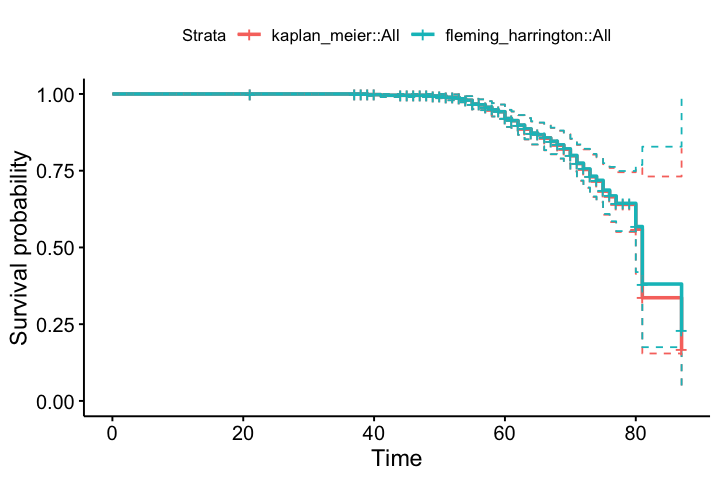

In [28]:
ggsurvplot(fits, thoracic, combine = TRUE, palette = "jco", conf.int = TRUE, conf.int.style = "step")

In [31]:
#fit the exponential model to the data
exponential_fit <- survreg(Surv(time, event) ~ 1, data = thoracic, dist="exponential")
lam_hat_exp <- exp(-exponential_fit$coefficients)
fit.dat.exp <- exp(-lam_hat_exp*c(0:90))

In [45]:
#fit the Weibull model to the data
weibull_fit <- survreg(Surv(AGE, Risk1Y) ~ 1, data = thoracic, dist="weibull")
lam_hat_wei <- exp(-weibull_fit$coefficients)
alpha <- 1/weibull_fit$scale
fit.dat.wei <- exp(-(lam_hat_wei * c(0:90))^alpha)

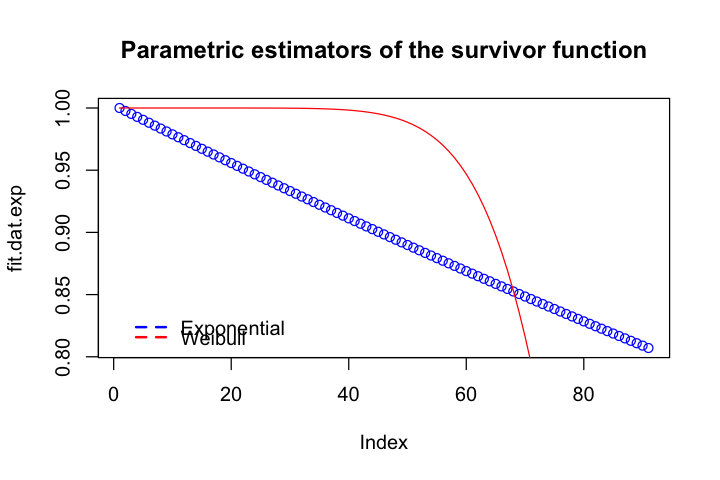

In [44]:
# plot
plot(fit.dat.exp, col = "blue")
lines(fit.dat.wei, col = "red")
legend("bottomleft", inset=.04,
     legend =  c("Exponential", "Weibull"),
      col =  c("blue", "red"),
     lwd=c(2,2), lty=c(2,2),
     box.lty=0)
title(main="Parametric estimators of the survivor function")

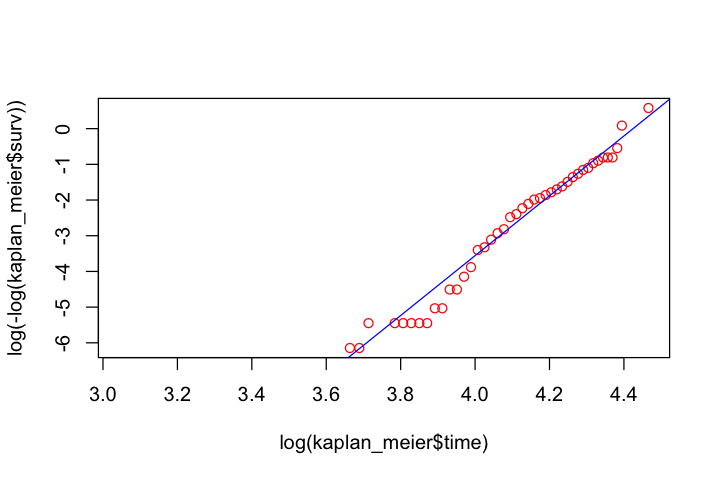

In [47]:
# Is the Weibull model adequate for the data?
plot(log(kaplan_meier$time) ,log(-log(kaplan_meier$surv)), col = "red")
abline(a = alpha*log(lam_hat_wei), b = alpha, col = "blue" )

In [49]:
# Proportion of smokers in the group
sum(thoracic$PRE30)/nrow(thoracic) * 100

[1] 82.12766

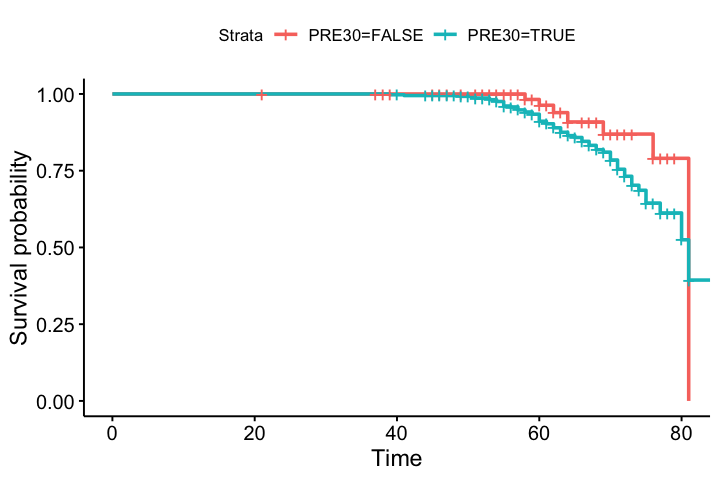

In [51]:
# Kaplan-Meier estimators for each group
fit <- survfit(Surv(time, event) ~ PRE30, data = thoracic)

ggsurvplot(fit, data = thoracic)

In [52]:
#Test formally if the survival time depends on being a smoker using the log-rank test
survdiff(Surv(time, event) ~ PRE30, data = thoracic, rho=0)

Call:
survdiff(formula = Surv(time, event) ~ PRE30, data = thoracic, 
    rho = 0)

              N Observed Expected (O-E)^2/E (O-E)^2/V
PRE30=FALSE  84        7     12.2      2.19      2.72
PRE30=TRUE  386       63     57.8      0.46      2.72

 Chisq= 2.7  on 1 degrees of freedom, p= 0.1 

In [56]:
#Fit the Weibull model to both groups: we do it by spliting the data into smokers and non-smokers
thoracic.smokers <- thoracic %>%
  filter(PRE30 == "TRUE")

#fitting the Weibull model to smokers' group
wei_smokers_fit <- survreg(Surv(time, event) ~ 1, data = thoracic.smokers, dist="weibull")
lam_hat_wei_smokers <- exp(-wei_smokers_fit$coefficients)
alpha_smokers <- 1/wei_smokers_fit$scale
fit.dat.wei.smokers <- exp(-(lam_hat_wei_smokers*c(0:90))^alpha_smokers)

In [57]:
thoracic.nonsmokers <- thoracic %>%
  filter(PRE30 == "FALSE")

#fitting the Weibull model to nonsmokers' group
wei_nonsmokers_fit <- survreg(Surv(time, event) ~ 1, data = thoracic.nonsmokers, dist="weibull")
lam_hat_wei_nonsmokers <- exp(-wei_nonsmokers_fit$coefficients)
alpha_nonsmokers <- 1/wei_nonsmokers_fit$scale
fit.dat.wei.nonsmokers <- exp(-(lam_hat_wei_nonsmokers*c(0:90))^alpha_nonsmokers)

In [59]:
#Computing nonparametric estimators of the survivor function: Kaplan-Meier
kaplan_meier_smokers <- survfit(Surv(time, event) ~ 1, data = thoracic.smokers, type = "kaplan-meier")
kaplan_meier_nonsmokers <- survfit(Surv(time, event) ~ 1, data = thoracic.nonsmokers, type = "kaplan-meier")

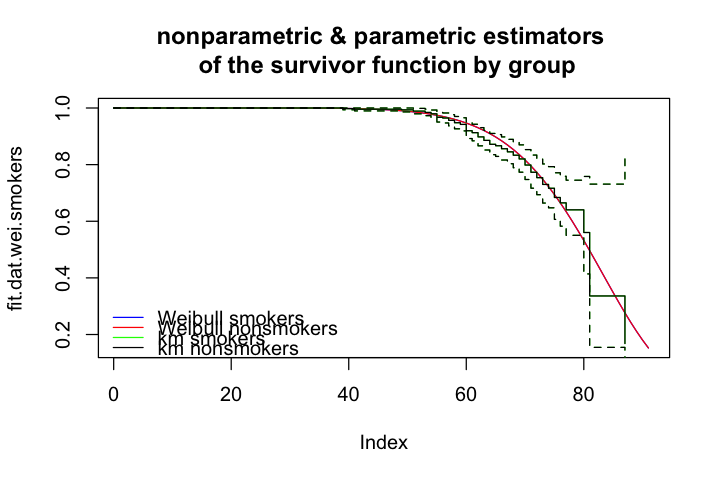

In [60]:
#plot
plot(fit.dat.wei.smokers, col = "blue", type = "l")
lines(fit.dat.wei.nonsmokers, col='red')
lines(kaplan_meier_smokers, col = "green")
lines(kaplan_meier_nonsmokers, col = "black")
legend("bottomleft", inset=.0001,
       legend =  c("Weibull smokers", "Weibull nonsmokers", "km smokers", "km nonsmokers"),
       col =  c("blue", "red", "green", "black"),
       lwd=c(1,1), lty=c(1,1),
       box.lty=0)
title(main="nonparametric & parametric estimators \n of the survivor function by group")

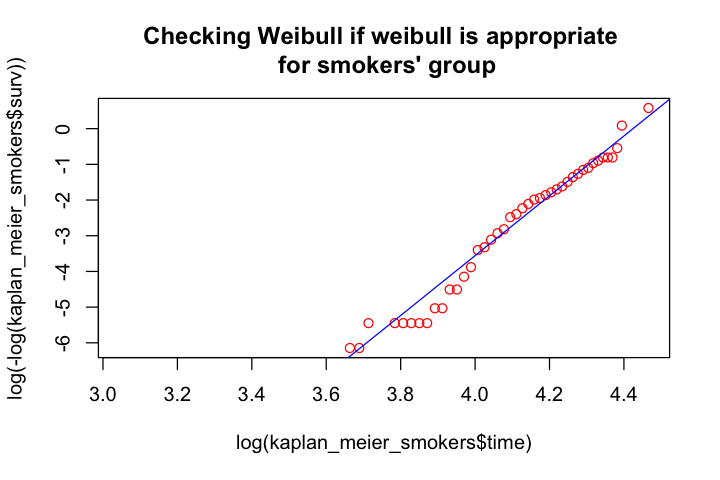

In [61]:
#Is the Weibull model an appropriate assumption in both groups
plot(log(kaplan_meier_smokers$time) ,log(-log(kaplan_meier_smokers$surv)), col = "red")
abline(a = alpha_smokers*log(lam_hat_wei_smokers), b = alpha_smokers, col = "blue" )
title(main="Checking Weibull if weibull is appropriate \n for smokers' group")

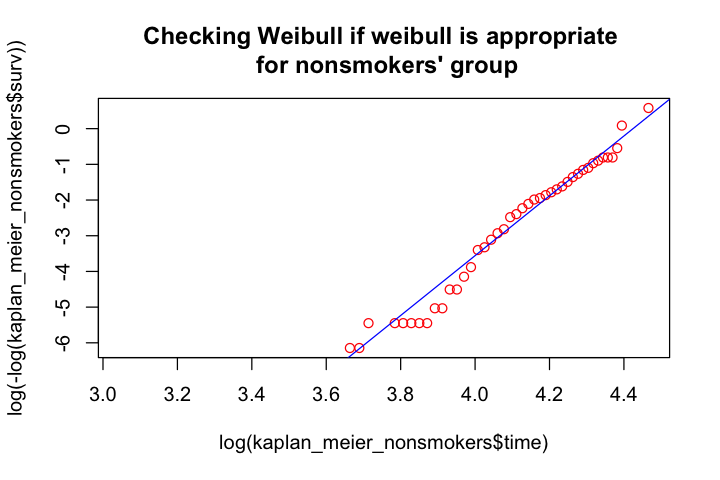

In [62]:
plot(log(kaplan_meier_nonsmokers$time) ,log(-log(kaplan_meier_nonsmokers$surv)), col = "red")
abline(a = alpha_nonsmokers*log(lam_hat_wei_nonsmokers), b = alpha_nonsmokers, col = "blue" )
title(main="Checking Weibull if weibull is appropriate \n for nonsmokers' group")